# Download,  Parse and Interrogate Apple Health Export Data

The first part of this program is all about getting the Apple Health export and putting it into an analyzable format. At that point it can be analysed anywhere. The second part of this program is concerned with using SAS Scripting Wrapper for Analytics Transfer (SWAT) Python library to transfer the data to SAS Viya, and analyze it there. The SWAT package provides native python language access to the SAS Viya codebase.

> https://github.com/sassoftware/python-swat

This file was created from a desire to get my hands on data collected by Apple Health, notably heart rate information collected by Apple Watch. For this to work, this file needs to be in a location accessible to Python code. A little bit of searching told me that iCloud file access is problematic and that there were already a number of ways of doing this with the Google API if the file was saved to Google Drive. I chose PyDrive. So for the end to end program to work with little user intervention, you will need to sign up for Google Drive, set up an application in the Google API and install Google Drive app to your iPhone. 

This may sound involved, and it is not necessary if you simply email the export file to yourself and copy it to a filesystem that Python can see. If you choose to do that, all of the Google Drive portion can be removed. I like the Google Drive process though as it enables a minimal manual work scenario.

This version requires the user to grant Google access, requiring some additional clicks, but it is not too much. I think it is possible to automate this to run without user intervention as well using security files.

The first step to enabling this process is exporting the data from Apple Health. As of this writing, open Apple Health and click on your user icon or photo. Near the bottom of the next page in the app will be a button or link called Export Health Data. Clicking on this will generate a xml file, zipped up. THe next dialog will ask you where you want to save it. Options are to email, save to iCloud, message etc...  Select Google Drive. Google Drive allows multiple  files with the same name and this is accounted for by this program.

In [38]:
import xml.etree.ElementTree as et
import pandas as pd
import numpy as np
from datetime import *

import matplotlib.pyplot as plt
import re 
import os.path
import zipfile
import pytz

%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 8

##  Authenticate with Google 
This will open a browser to let you beging the process of authentication with an existing Google Drive account. This process will be separate from Python. For this to work, you will need to set up a Other Authentication OAuth credential at https://console.developers.google.com/apis/credentials, save the secret file in your root directory and a few other things that are detailed at https://pythonhosted.org/PyDrive/. The PyDrive instructions also show you how to set up your Google application. There are other methods for accessing the Google API from python, but this one seems pretty nice. 
The first time through the process, regular sign in and two factor authentication is required (if you require two factor auth) but after that it is just a process of telling Google that it is ok for your Google application to access Drive.

In [39]:
# Authenticate into Google Drive
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() 

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=643038572377-3l8prnqdfm6o5ualucljs78l9vao60qb.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


### Download the most recent Apple Health export file
Now that we are authenticated into Google Drive, use PyDrive to access the API and get to files stored.

Google Drive allows multiple files with the same name, but it indexes them with the ID to keep them separate.
In this block, we make one pass of the file list where the file name is called export.zip, and save the row that corresponds with the most recent date. We will use that  file id later to download the correct file that corresponds  with the most recent date. Apple Health export names the file export.zip, and at the time this was written, there is no other option.

In [40]:
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)

file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()

# Step through the file list and find the most current export.zip file id, then use 
#      that later to download the file to the local machine.
# This may look a little old school, but these file lists will never be massive and 
#     it is readable and easy one pass way to get the most current file using the 
#     least (or low) amount of resouces

selection_dt = datetime.strptime("2000-01-01T01:01:01.001Z","%Y-%m-%dT%H:%M:%S.%fZ")
print("Matching Files")
for file1 in file_list: 
    if re.search("^export-*\d*.zip",file1['title']):
        dt = datetime.strptime(file1['createdDate'],"%Y-%m-%dT%H:%M:%S.%fZ")
        if dt > selection_dt:
            selection_id = file1['id']
            selection_dt = dt
        print('    title: %s, id: %s createDate: %s' % (file1['title'], file1['id'], file1['createdDate']))

Matching Files
    title: export.zip, id: 1ubIB_ZsD-M1-gPBRc0cUAInPwzGPwTeo createDate: 2019-11-07T23:24:37.647Z
    title: export.zip, id: 19HXS3sqPRLYC9dSNP74SoKClsXm3C6TU createDate: 2019-11-03T19:33:53.626Z
    title: export.zip, id: 1XIDW7HVck0J73ySWaMLiK3rsfXYgNrdE createDate: 2019-09-15T12:25:46.285Z
    title: export-11.zip, id: 1z6aWf0Lg3G-QlvXJVucWJ-5P2EPFV66k createDate: 2018-06-21T12:44:25.865Z


In [41]:
if not os.path.exists('healthextract'):
    os.mkdir('healthextract')

## Download the file from Google Drive
Ensure that the file downloaded is the latest file generated

In [42]:
for file1 in file_list:
        if file1['id'] == selection_id:
            print('Downloading this file: %s, id: %s createDate: %s' % (file1['title'], file1['id'], file1['createdDate']))
            file1.GetContentFile("healthextract/export.zip")

## Unzip the most current file to a holding directory

In [43]:
zip_ref = zipfile.ZipFile('healthextract/export.zip', 'r')
zip_ref.extractall('healthextract')
zip_ref.close()

## Parse Apple Health Export document

In [44]:
path = "/Users/samuelcroker/Documents/repositories/RHealthDataImport/healthextract/apple_health_export/export.xml"
e = et.parse(path)
#this was from an older iPhone, to demonstrate how to join files
#legacy = et.parse("/Users/samuelcroker/Documents/repositories/RHealthDataImport/healthextract/apple_health_export/export.xml")

## List XML headers by element count

In [45]:
pd.Series([el.tag for el in e.iter()]).value_counts()

Record                              1624395
MetadataEntry                        175917
InstantaneousBeatsPerMinute           20599
ClinicalRecord                         7614
ActivitySummary                        1183
HeartRateVariabilityMetadataList        323
Workout                                  25
WorkoutEvent                             17
FileReference                            12
WorkoutRoute                             12
Correlation                               9
HealthData                                1
ExportDate                                1
Me                                        1
dtype: int64

## List types for "Record" Header

In [46]:
pd.Series([atype.get('type') for atype in e.findall('Record')]).value_counts()

HKQuantityTypeIdentifierActiveEnergyBurned            857201
HKQuantityTypeIdentifierHeartRate                     275326
HKQuantityTypeIdentifierBasalEnergyBurned             196389
HKQuantityTypeIdentifierDistanceWalkingRunning        129615
HKQuantityTypeIdentifierStepCount                     127670
HKCategoryTypeIdentifierAppleStandHour                 21536
HKQuantityTypeIdentifierAppleExerciseTime               8181
HKQuantityTypeIdentifierFlightsClimbed                  5337
HKQuantityTypeIdentifierEnvironmentalAudioExposure      1395
HKQuantityTypeIdentifierAppleStandTime                  1189
HKQuantityTypeIdentifierHeartRateVariabilitySDNN         323
HKQuantityTypeIdentifierPeripheralPerfusionIndex          37
HKQuantityTypeIdentifierRestingHeartRate                  32
HKQuantityTypeIdentifierOxygenSaturation                  31
HKQuantityTypeIdentifierWalkingHeartRateAverage           30
HKQuantityTypeIdentifierHeadphoneAudioExposure            29
HKQuantityTypeIdentifier

# Extract Values to Data Frame
TODO: Abstraction of the next code block

In [47]:
import pytz

#Extract the heartrate values, and get a timestamp from the xml
# there is likely a more efficient way, though this is very fast
def txloc(xdate,fmt):
    eastern = pytz.timezone('US/Eastern')
    dte = xdate.astimezone(eastern)
    return datetime.strftime(dte,fmt)

def xmltodf(eltree, element,outvaluename):
    dt = []
    v = []
    for atype in eltree.findall('Record'):
        if atype.get('type') == element:    
            dt.append(datetime.strptime(atype.get("startDate"),"%Y-%m-%d %H:%M:%S %z"))
            v.append(float(atype.get("value")))
            

    myd = pd.DataFrame({"Create":dt,outvaluename:v})
    colDict = {"Year":"%Y","Month":"%Y-%m", "Week":"%Y-%U","Day":"%d","Hour":"%H","Days":"%Y-%m-%d","Month-Day":"%m-%d"}
    for col, fmt in colDict.items():
        myd[col] = myd['Create'].dt.tz_convert('US/Eastern').dt.strftime(fmt)

    myd[outvaluename] = myd[outvaluename].astype(float) #.astype(int)
    print('Extracting ' + outvaluename + ', type: ' + element)
  
    return(myd)

HR_df = xmltodf(e,"HKQuantityTypeIdentifierHeartRate","HeartRate")
HA_df = xmltodf(e,"HKQuantityTypeIdentifierEnvironmentalAudioExposure","EnvAudio")
EX_df = xmltodf(e,"HKQuantityTypeIdentifierAppleExerciseTime","Extime")

SPO2_df = xmltodf(e,"HKQuantityTypeIdentifierOxygenSaturation","SPO2")

Extracting HeartRate, type: HKQuantityTypeIdentifierHeartRate
Extracting EnvAudio, type: HKQuantityTypeIdentifierEnvironmentalAudioExposure
Extracting Extime, type: HKQuantityTypeIdentifierAppleExerciseTime
Extracting SPO2, type: HKQuantityTypeIdentifierOxygenSaturation


In [30]:
HR_df

,Create,HeartRate,Year,Month,Week,Day,Hour,Days,Month-Day
0,2016-07-01 10:03:16-05:00,81,2016,2016-07,2016-26,01,11,2016-07-01,07-01
1,2016-07-01 10:06:50-05:00,78,2016,2016-07,2016-26,01,11,2016-07-01,07-01
2,2016-07-01 10:11:52-05:00,61,2016,2016-07,2016-26,01,11,2016-07-01,07-01
3,2016-07-01 10:17:37-05:00,73,2016,2016-07,2016-26,01,11,2016-07-01,07-01
4,2016-07-01 10:23:02-05:00,74,2016,2016-07,2016-26,01,11,2016-07-01,07-01
...,...,...,...,...,...,...,...,...,...
275321,2019-11-07 16:53:16-05:00,110,2019,2019-11,2019-44,07,16,2019-11-07,11-07
275322,2019-11-07 16:59:11-05:00,105,2019,2019-11,2019-44,07,16,2019-11-07,11-07
275323,2019-11-07 17:47:54-05:00,110,2019,2019-11,2019-44,07,17,2019-11-07,11-07
275324,2019-11-07 17:47:56-05:00,30,2019,2019-11,2019-44,07,17,2019-11-07,11-07


In [32]:
#reset plot - just for tinkering 
plt.rcParams['figure.figsize'] = 60, 8

(40, 140)

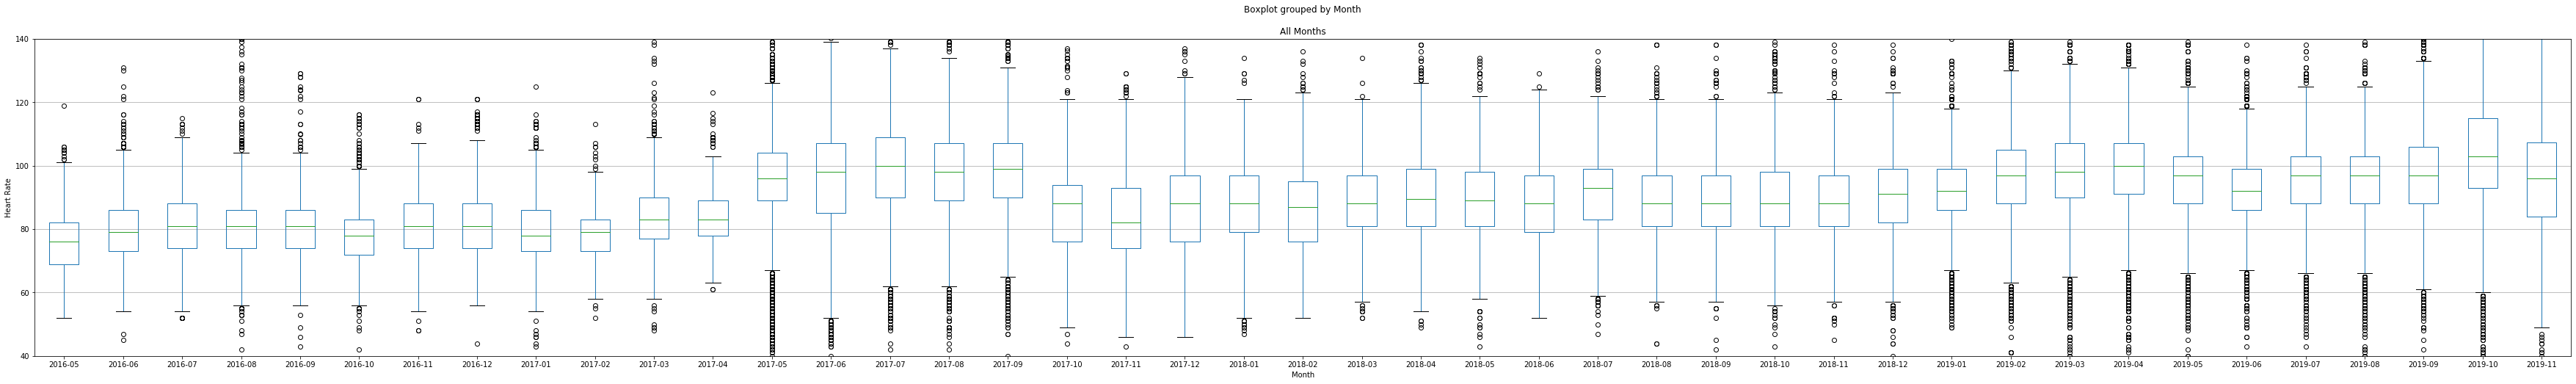

In [33]:
HR_df.boxplot(by='Month',column="HeartRate", return_type='axes')
plt.grid(axis='x')
plt.title('All Months')
plt.ylabel('Heart Rate')
plt.ylim(40,140)

(40, 140)

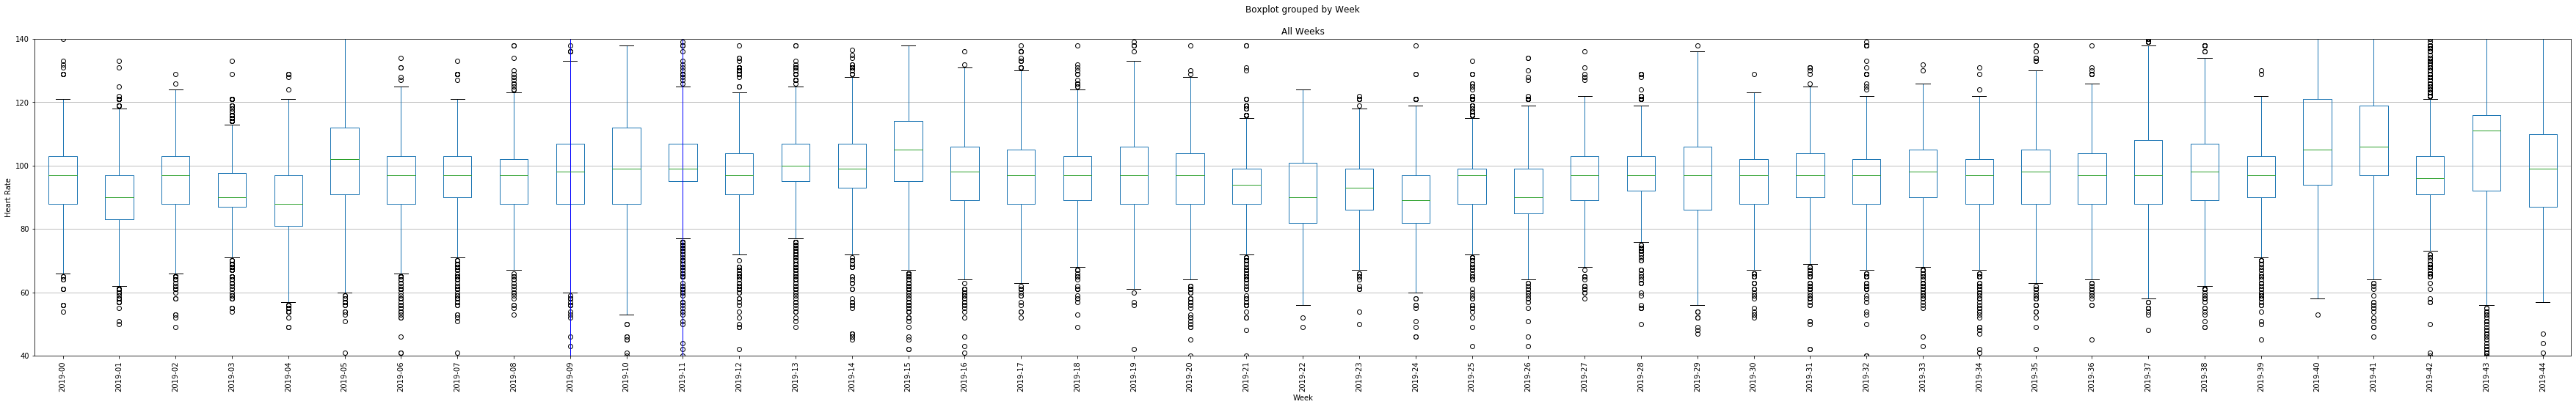

In [34]:
dx = HR_df[HR_df['Year']=='2019'].boxplot(by='Week',column="HeartRate", return_type='axes')
plt.title('All Weeks')
plt.ylabel('Heart Rate')
plt.xticks(rotation=90)
plt.grid(axis='x')
[plt.axvline(_x, linewidth=1, color='blue') for _x in [10,12]]
plt.ylim(40,140)

(40, 140)

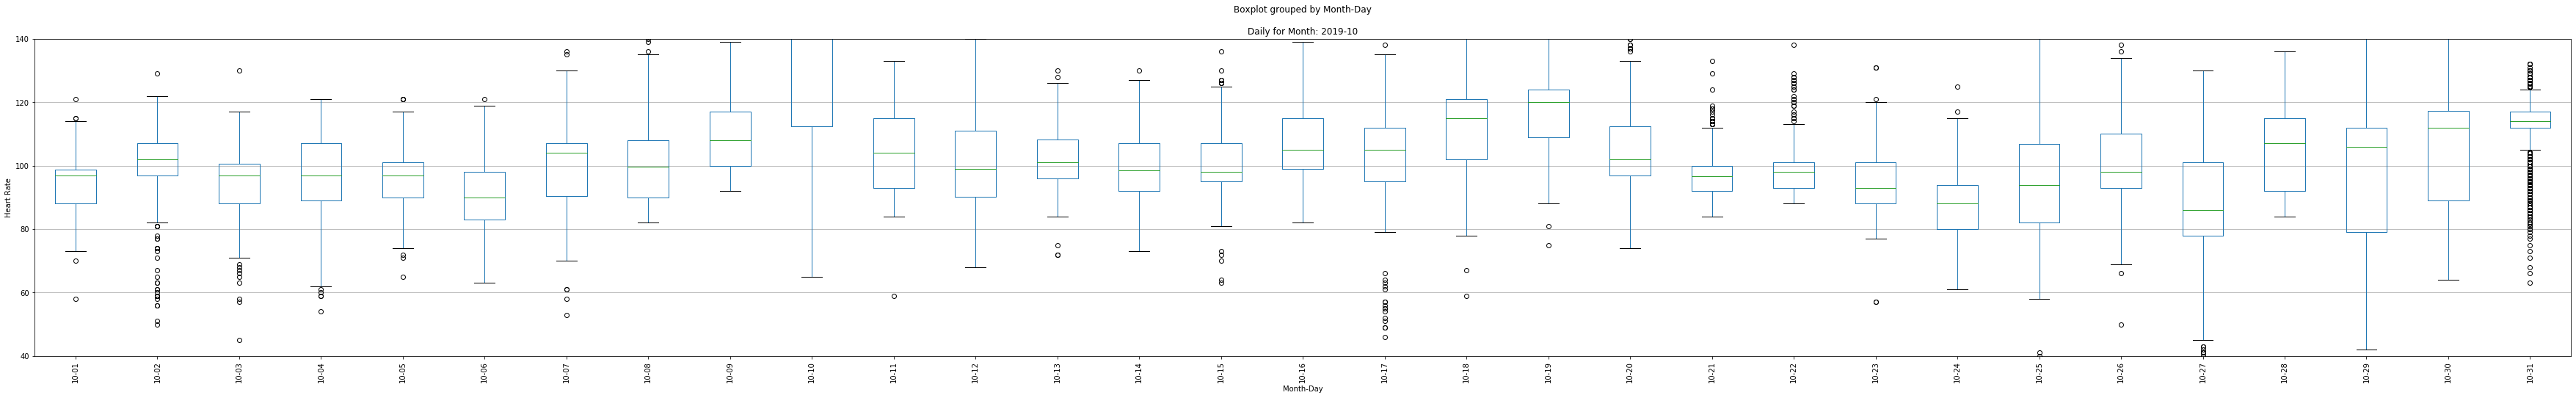

In [35]:
monthval = '2019-10'
#monthval1 = '2017-09'
#monthval2 = '2017-10'
#HR_df[(HR_df['Month']==monthval1) | (HR_df['Month']== monthval2)].boxplot(by='Month-Day',column="HeartRate", return_type='axes')
HR_df[HR_df['Month']==monthval].boxplot(by='Month-Day',column="HeartRate", return_type='axes')
plt.grid(axis='x') 
plt.rcParams['figure.figsize'] = 16, 8
plt.title('Daily for Month: '+ monthval)
plt.ylabel('Heart Rate')
plt.xticks(rotation=90)
plt.ylim(40,140)

(40, 140)

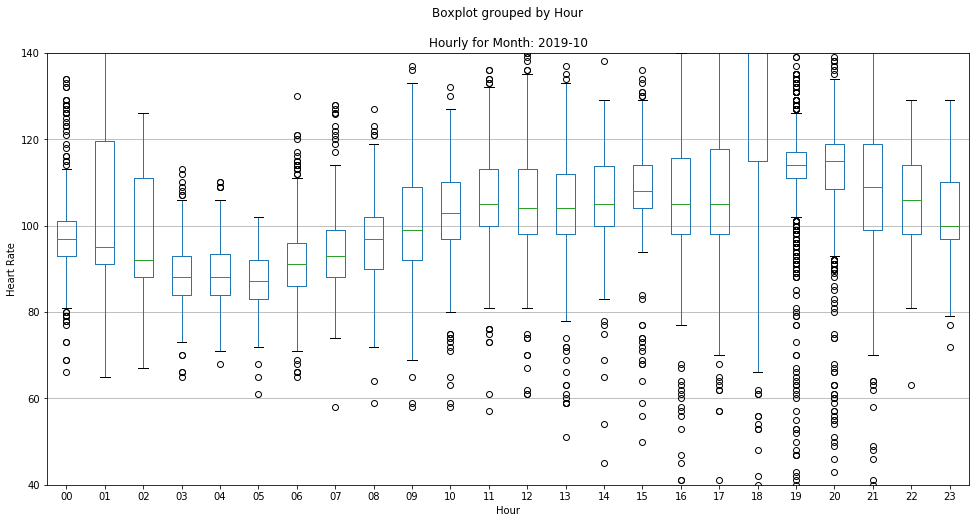

In [36]:
HR_df[HR_df['Month']==monthval].boxplot(by='Hour',column="HeartRate")
plt.title('Hourly for Month: '+ monthval)
plt.ylabel('Heart Rate')
plt.grid(axis='x')
plt.ylim(40,140)

import calmap
ts = pd.Series(HR_df['HeartRate'].values, index=HR_df['Days'])
ts.index = pd.to_datetime(ts.index)
tstot = ts.groupby(ts.index).median()

plt.rcParams['figure.figsize'] = 16, 8
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
calmap.yearplot(data=tstot,year=2017)

### Flag Chemotherapy Days for specific analysis

The next two cells provide the ability to introduce cycles that start on specific days and include this data in the datasets so that they can be overlaid in graphics. In the example below, there are three cycles of 21 days. The getDelta function returns the cycle number when tpp == 0 and the days since day 0 when tpp == 2. This allows the overlaying of the cycles, with the days since day 0 being overlaid.

In [29]:
# This isnt efficient yet, just a first swipe. It functions as intended.
def getDelta(res,ttp,cyclelength):
    mz = [x if (x >= 0) & (x < cyclelength) else 999 for x in res]
    if ttp == 0:
        return(mz.index(min(mz))+1)
    else:
        return(mz[mz.index(min(mz))])

#chemodays = np.array([date(2017,4,24),date(2017,5,16),date(2017,6,6),date(2017,8,14)])
chemodays = np.array([date(2018,1,26),date(2018,2,2),date(2018,2,9),date(2018,2,16),date(2018,2,26),date(2018,3,2),date(2018,3,19),date(2018,4,9),date(2018,5,1),date(2018,5,14),date(2018,6,18),date(2018,7,10),date(2018,8,6)])

HR_df = xmltodf(e,"HKQuantityTypeIdentifierHeartRate","HeartRate")
#I dont think this is efficient yet...
a = HR_df['Create'].apply(lambda x: [x.days for x in x.date()-chemodays])
HR_df['ChemoCycle'] = a.apply(lambda x: getDelta(x,0,21))
HR_df['ChemoDays'] = a.apply(lambda x: getDelta(x,1,21))

Extracting HeartRate, type: HKQuantityTypeIdentifierHeartRate


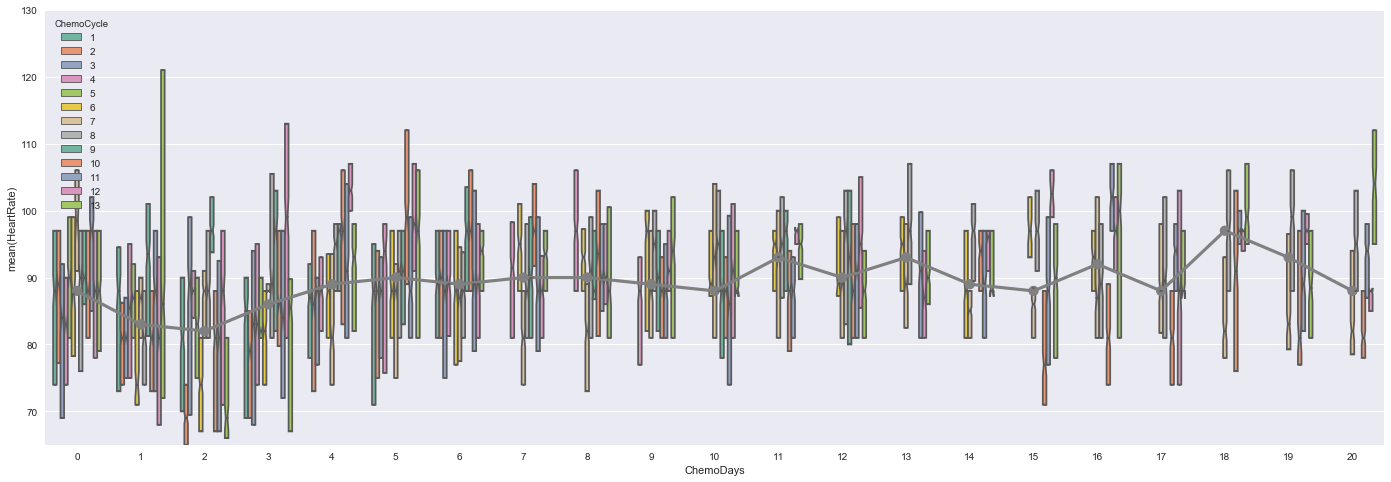

In [30]:
import seaborn as sns
plotx = HR_df[HR_df['ChemoDays']<=21]
plt.rcParams['figure.figsize'] = 24, 8
ax = sns.boxplot(x="ChemoDays", y="HeartRate", hue="ChemoCycle", data=plotx, palette="Set2",notch=1,whis=0,width=0.75,showfliers=False)
plt.ylim(65,130)
#the next statement puts the chemodays variable as a rowname, we need to fix that
plotx_med = plotx.groupby('ChemoDays').median()
#this puts chemodays back as a column in the frame. I need to see if there is a way to prevent the effect
plotx_med.index.name = 'ChemoDays'
plotx_med.reset_index(inplace=True)

snsplot = sns.pointplot(x='ChemoDays', y="HeartRate", data=plotx_med,color='Gray')

## Boxplots Using Seaborn

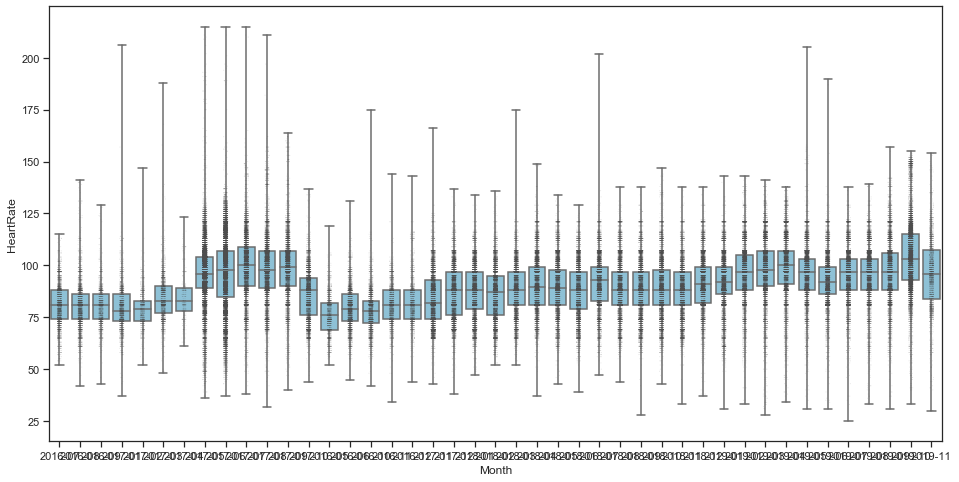

In [37]:
import seaborn as sns
sns.set(style="ticks", palette="muted", color_codes=True)

sns.boxplot(x="Month", y="HeartRate", data=HR_df,whis=np.inf, color="c")
# Add in points to show each observation
snsplot = sns.stripplot(x="Month", y="HeartRate", data=HR_df,jitter=True, size=1, alpha=.15, color=".3", linewidth=0)

In [24]:
hr_only = HR_df[['Create','HeartRate']]
hr_only.tail()

,Create,HeartRate
220457,2019-03-09 19:25:45-05:00,76
220458,2019-03-09 19:33:16-05:00,112
220459,2019-03-09 19:36:50-05:00,117
220460,2019-03-09 19:41:29-05:00,115
220461,2019-03-09 19:44:58-05:00,68


In [25]:
hr_only.to_csv('~/Downloads/stc_hr.csv')